In [40]:
### Pyhton 3.7.1 ###
#-----L5 2-way ANOVA------
#~~packages
import pandas as pd
import scipy.stats as stats
import numpy as np
#time
import time
tStart = time.time()
#install scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
#install matplotlib
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#data visualization
import seaborn as sns
#R packages
import rpy2.robjects as robjects
#pingouin (ANOVA)
import pingouin as pi

In [41]:
#~~ loading data
df_raw = pd.read_csv(r"C:\Users\johnson_yang\Desktop\WOW_data_forStudent.csv")#改成自己的檔案位置

#~~ checking data
df = df_raw[['ID','ethnic','gender','reading_3']]
print('---------------------Data info_head---------------------')
print(df.head())
print('---------------------Data type---------------------')
print(df.dtypes)
print('---------------------ID info---------------------')
df[['ID']]=df[['ID']].astype('object')
print(df.dtypes)

---------------------Data info_head---------------------
        ID  ethnic  gender  reading_3
0  1041002  Human        0        492
1  1041007  Human        0        494
2  1041008  Human        0        523
3  1041012  Human        1        476
4  1041020  Human        0        515
---------------------Data type---------------------
ID            int64
ethnic       object
gender        int64
reading_3     int64
dtype: object
---------------------ID info---------------------
ID           object
ethnic       object
gender        int64
reading_3     int64
dtype: object


C:\Users\johnson_yang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [42]:
#~~ Replace with number with gender
df[['gender']]=df[['gender']].replace([1,0],['male','female'])
print(df[['gender']].head())

#~~ Descriptive stats
print('----------------DV-----------------')
print(df[['reading_3']].describe())
print('----------------IV1-----------------')
print(df['ethnic'].value_counts())
print('----------------IV2-----------------')
print(df['gender'].value_counts())

   gender
0  female
1  female
2  female
3    male
4  female
----------------DV-----------------
        reading_3
count  193.000000
mean   499.326425
std     19.092761
min    423.000000
25%    489.000000
50%    503.000000
75%    512.000000
max    543.000000
----------------IV1-----------------
Human      87
Undead     64
Orc        42
Name: ethnic, dtype: int64
----------------IV2-----------------
male      104
female     89
Name: gender, dtype: int64


In [43]:
#~~ Normality
print(stats.describe(df['reading_3']))

DescribeResult(nobs=193, minmax=(423, 543), mean=499.3264248704663, variance=364.53351683937825, skewness=-0.9125744541449188, kurtosis=1.6503736513748368)


In [51]:
#~~ Using R's packages to run homogeneity test
rr=robjects.r
rr('indaov2 <- read.csv("C:/Users/johnson_yang/Desktop/WOW_data_forStudent.csv",header=TRUE)')
rr('install.packages("car")')
rr('install.packages("plyr")')
rr('library(car)')
rr('library(plyr)')
rr('indaov2$gender <- mapvalues(indaov2$gender, from = c(0,1), to = c("female","male"))')
rr('indaov2$gender <- as.factor(indaov2$gender)')
print(rr('bartlett.test(reading_3 ~ ethnic, data=indaov2)'))
print(rr('leveneTest(reading_3 ~ gender, data=indaov2)'))

#python進行變異數同質性檢驗的作法之前教過，請參考前幾章的做法



	Bartlett test of homogeneity of variances



data:  reading_3 by ethnic

Bartlett's K-squared = 3.3976, df = 2, p-value = 0.1829



Levene's Test for Homogeneity of Variance (center = median)

       Df F value Pr(>F)

group   1   2e-04 0.9898

      191               



In [52]:
# ~~ 2-way anova
# R

rr('install.packages("stats")')
rr('library(stats)')
rr('indaov2.op <- aov(reading_3 ~ ethnic*gender, data=indaov2)' )
print(rr('summary(indaov2.op)'))


# python (由於數值與R有差異，因此這裡教同學引用R套件的做法)

#results=pi.anova(dv='reading_3', between=['ethnic','gender'], data=df, detailed=True, export_filename=None)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(results)

               Df Sum Sq Mean Sq F value  Pr(>F)    

ethnic          2  10758    5379  17.475 1.1e-07 ***

gender          1    892     892   2.898  0.0904 .  

ethnic:gender   2    781     391   1.269  0.2835    

Residuals     187  57560     308                    

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



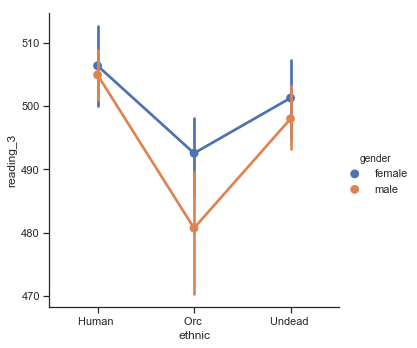

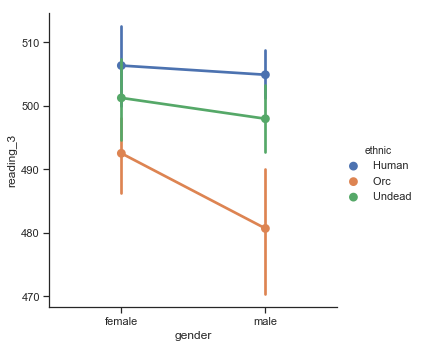

In [53]:
# plot
sns.catplot(x="ethnic", y="reading_3", hue="gender", kind="point", data=df)
sns.catplot(x="gender", y="reading_3", hue="ethnic", kind="point", data=df)
plt.show()

In [54]:
#  Using R's packages to get etaSquared
rr('install.packages("lsr")')
rr('library(lsr)')
print(rr('etaSquared(indaov2.op, anova=TRUE)'))

                  eta.sq eta.sq.part         SS  df        MS         F

ethnic        0.15465410  0.15828731 10824.3079   2 5412.1539 17.583035

gender        0.01274451  0.01526038   891.9939   1  891.9939  2.897915

ethnic:gender 0.01116161  0.01339038   781.2058   2  390.6029  1.268993

Residuals     0.82239262          NA 57559.6176 187  307.8054        NA

                         p

ethnic        1.006519e-07

gender        9.035592e-02

ethnic:gender 2.835240e-01

Residuals               NA



In [55]:
# Using R's packages to run post-hoc(scheffe.test)
rr('install.packages("agricolae")')
rr('library(agricolae)')
rr('sch <- scheffe.test(indaov2.op, "ethnic", group=F)')
print(rr('sch$comparison'))

                 Difference pvalue sig        LCL       UCL

Human  - Orc      19.481117 0.0000 ***  12.158084 26.804149

Human  - Undead    5.919361 0.1255      -0.498928 12.337649

Orc  - Undead    -13.561756 0.0007 *** -21.301359 -5.822153

